In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

### Question 2.1: Generate m Snapshot Data

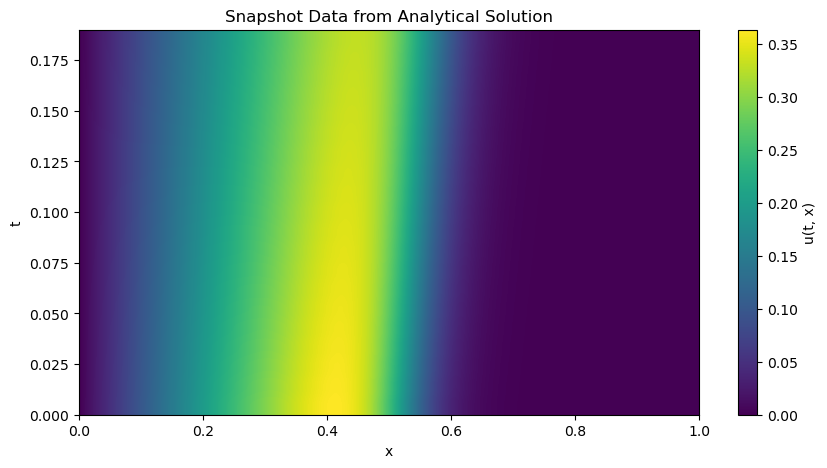

In [38]:
# Constants
Re = 100
t_0 = np.exp(Re / 8)
dt = 1e-2  # Time step
dx = 1e-3  # Spatial grid length
m = 20  # Number of snapshots

# Exact solution function
def exact_solution(x, t):
    numerator = x / (t + 1)
    denominator = 1 + np.sqrt((t + 1) / t_0) * np.exp(Re * x**2 / (4 * t + 4))
    return numerator / denominator

# Generate spatial and temporal grids
x_values = np.arange(0, 1 + dx, dx)  # x in [0, 1]
t_values = np.arange(0, m * dt, dt)[:m]  # m time steps

# Generate the dataframe for u(ti, xj) with boundary conditions
u_values = []
for t in t_values:
    u_t = exact_solution(x_values, t)
    
    # Apply boundary conditions
    u_t[0] = 0  # u(0, t) = 0
    u_t[-1] = 0  # u(1, t) = 0
    
    u_values.append(u_t)

# Create a pandas DataFrame
u_df = pd.DataFrame(u_values, columns=x_values)

# Display first few rows to verify
# print(u_df.head())

# Visualize snapshot data
plt.figure(figsize=(10, 5))
plt.imshow(u_df, extent=[x_values.min(), x_values.max(), t_values.min(), t_values.max()], aspect='auto', origin='lower')
plt.colorbar(label="u(t, x)")
plt.title("Snapshot Data from Analytical Solution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

### Question 2.2: Construct ROM and Determine t∗

### Question 2.3: Predict Full-Order Solutions Up to t∗

### Question 2.4: Repeat Steps 1-3 Until T=2.0

In [39]:
# Convert the DataFrame to a NumPy array
u_matrix = u_df.values  # Convert DataFrame to a NumPy array for SVD

# Perform Singular Value Decomposition (SVD)
U, S, V = svd(u_matrix, full_matrices=False)

# Convert the singular values into a diagonal matrix
S_matrix = np.diag(S)  # Create a diagonal matrix from the singular values

# Create DataFrames for the SVD components (U, S, V)
U_df = pd.DataFrame(U, index=u_df.index, columns=[f"U{i+1}" for i in range(U.shape[1])])  # Left singular vectors
S_df = pd.DataFrame(S_matrix, index=[f"S{i+1}" for i in range(S_matrix.shape[0])],
                    columns=[f"S{i+1}" for i in range(S_matrix.shape[1])])  # Singular values (diagonal matrix)
V_df = pd.DataFrame(V, columns=u_df.columns, index=[f"V{i+1}" for i in range(V.shape[0])])  # Right singular vectors

# Convert back to NumPy arrays for computation
U = U_df.values  # Left singular vectors
S = np.diag(S_df.values.diagonal())  # Singular values as a diagonal matrix
V = V_df.values  # Right singular vectors

# Initialize the rank-k approximation matrix
A_k = np.zeros((len(t_values), len(x_values)))  # Initialize the rank-k approximation matrix

# Truncate to rank-k approximation (k = 2)
k = 2
U_k = U[:, :k]  # Truncated left singular vectors (U_k)
S_k = S[:k, :k]  # Truncated singular values (S_k)
V_k = V[:k, :]  # Truncated right singular vectors (V_k)

# Compute the rank-k approximation
for g in range(k):
    # Extract components for the g-th mode
    U_g = U_k[:, g]  # g-th column of U_k
    S_g = S_k[g, g]  # g-th singular value
    V_g = V_k[g, :]  # g-th row of V_k

    # Compute the contribution of the g-th mode and add to A_k
    A_k += S_g * (U_g.reshape(-1, 1) @ V_g.reshape(1, -1))  # Outer product for the g-th mode

# A_k now contains the rank-k approximation of the original matrix
# Convert A_k to a DataFrame for better interpretation (optional)
A_k_df = pd.DataFrame(A_k)  # Create a DataFrame for A_k

In [40]:
# Assuming U_k and t_values are already defined
# Simulate t_values and U_k for demonstration purposes
# Replace these with actual data in real usage
t_values = np.arange(0, m) * dt  # Time steps as input
U_k = U[:, :k]  # Use the first k=2 columns of the U matrix from SVD

# Initialize a list to store the Gaussian Process Regression (GPR) models
gpr_models = []

# Define the kernel for GPR (combination of constant kernel and RBF kernel)
kernel = C(100.0, (1e-3, 1e3)) * RBF(0.1, (1e-3, 1e3))

# Train a GPR model for each column of U_k
for i in range(U_k.shape[1]):
    # Create a GPR model with the defined kernel
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, random_state=0)
    
    # Fit the GPR model to the current column of U_k
    gpr.fit(t_values.reshape(-1, 1), U_k[:, i])
    
    # Append the trained model to the list
    gpr_models.append(gpr)

# Output trained models for inspection (optional)
for idx, model in enumerate(gpr_models):
    print(f"GPR Model for Component {idx + 1}:")
    print(model)

d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GPR Model for Component 1:
GaussianProcessRegressor(kernel=10**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=100, random_state=0)
GPR Model for Component 2:
GaussianProcessRegressor(kernel=10**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=100, random_state=0)


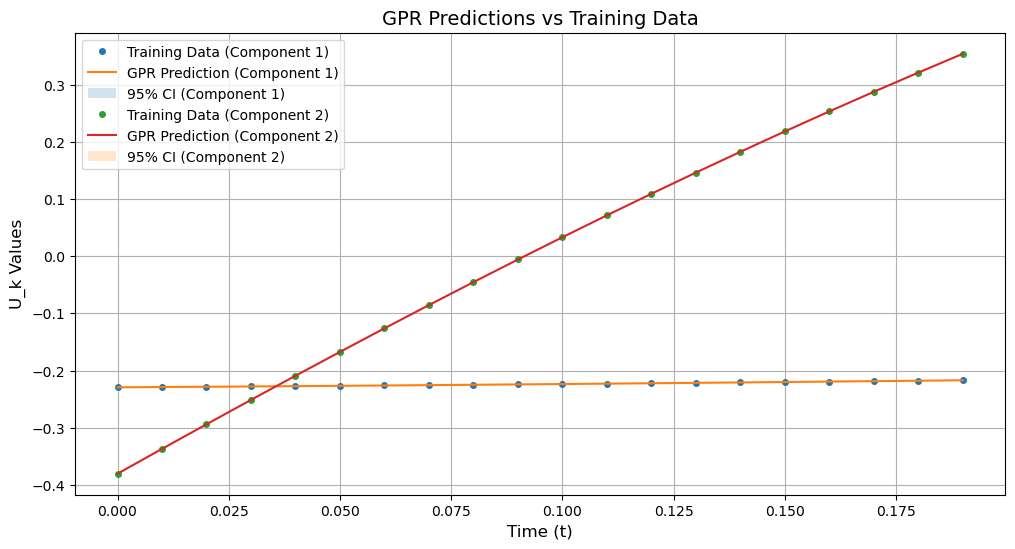

In [41]:
# Reshape the time values to match the input shape required by GPR
t_pred = t_values.reshape(-1, 1)  # Reshape t_values into a column vector for predictions

# Initialize lists to store predictions and standard deviations for each GPR model
predictions = []
std_devs = []

# Iterate over each GPR model and make predictions
for model in gpr_models:
    # Predict the mean and standard deviation of U_k for the current component
    pred, std = model.predict(t_pred, return_std=True)
    predictions.append(pred)  # Append the predicted mean values
    std_devs.append(std)  # Append the standard deviations (uncertainty)

# Convert predictions and standard deviations to numpy arrays for easier manipulation
predictions = np.array(predictions).T  # Shape: (len(t_values), U_k's number of components)
std_devs = np.array(std_devs).T  # Shape: (len(t_values), U_k's number of components)

# Plot the results
plt.figure(figsize=(12, 6))

# Loop through each component of U_k
for i in range(U_k.shape[1]):
    # Plot the original training data points for the current component
    plt.plot(t_values, U_k[:, i], 'o', label=f"Training Data (Component {i+1})", markersize=4)

    # Plot the predicted values from the GPR model
    plt.plot(t_values, predictions[:, i], '-', label=f"GPR Prediction (Component {i+1})")

    # Plot the 95% confidence interval (±2 standard deviations)
    plt.fill_between(t_values,
                     predictions[:, i] - 2 * std_devs[:, i],
                     predictions[:, i] + 2 * std_devs[:, i],
                     alpha=0.2, label=f"95% CI (Component {i+1})")

# Add plot title and labels
plt.title("GPR Predictions vs Training Data", fontsize=14)
plt.xlabel("Time (t)", fontsize=12)
plt.ylabel("U_k Values", fontsize=12)

# Add legend and grid
plt.legend(fontsize=10, loc="best")
plt.grid(True)

# Display the plot
plt.show()

Stopping prediction at t = 0.32 due to high uncertainty.


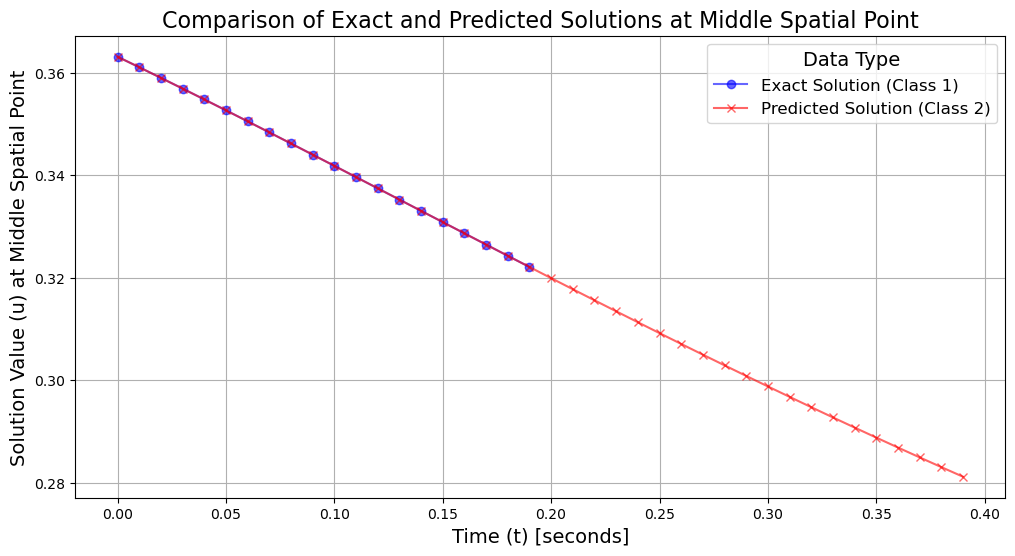

In [42]:
# Predict new time points
t_new = np.arange(0, 5 * m) * dt  # Generate new time points for prediction
t_new = t_new.reshape(-1, 1)  # Reshape to a column vector for GPR prediction

# Initialize lists to store predictions and uncertainties
predictions = []
std_devs = []

# Predict U_k components for new time points using each GPR model
for model in gpr_models:
    pred, std = model.predict(t_new, return_std=True)  # Predict mean and std deviation
    predictions.append(pred)  # Append predicted values
    std_devs.append(std)  # Append standard deviations

# Convert predictions and std deviations to NumPy arrays
predictions = np.array(predictions)  # Shape: (number of components, len(t_new))
std_devs = np.array(std_devs)  # Same shape as predictions

# Stop prediction if uncertainty exceeds the threshold
error_threshold = 0.001  # Define acceptable uncertainty level
for t_idx, t in enumerate(t_new.flatten()):
    if any(std[t_idx] > error_threshold for std in std_devs):
        print(f"Stopping prediction at t = {t:.2f} due to high uncertainty.")
        break

# Initialize the rank-k approximation matrix for predictions
A_pred = np.zeros((len(t_new), len(x_values)))

# Compute the predicted rank-k approximation
for g in range(k):
    U_g_pred = predictions[g].reshape(-1, 1)  # Predicted U_k component (column vector)
    S_g = S_k[g, g]  # Singular value for the g-th component
    V_g = V_k[g, :]  # Right singular vector (row) for the g-th component

    # Add contribution of the g-th mode to the approximation
    A_pred += S_g * (U_g_pred @ V_g.reshape(1, -1))

# Convert the predicted rank-k approximation to a DataFrame
A_pred_df = pd.DataFrame(A_pred)

# Prepare the final DataFrame for visualization
final = pd.DataFrame(columns=["t", "u", "class"])  # Initialize the DataFrame

# Extract exact solutions for the middle spatial point
middle_point_idx = 412  # Index of the middle spatial point
A_exact_middle = A_k_df.iloc[:, middle_point_idx]  # Exact solution values

# Populate the final DataFrame with exact solutions (Class 1)
final["t"] = t_values  # Time points
final["u"] = A_exact_middle  # Exact values
final["class"] = [1] * len(t_values)  # Class label for exact solutions

# Extract predicted solutions for the middle spatial point (Class 2)
t_new_values = t_new[:40].flatten()  # First 40 predicted time points
A_pred_middle = A_pred_df.iloc[:40, middle_point_idx]  # Predicted values

# Create a new DataFrame for predictions
new_rows = pd.DataFrame({
    "t": t_new_values,
    "u": A_pred_middle,
    "class": [2] * len(t_new_values)  # Class label for predictions
})

# Append predictions to the final DataFrame
final = pd.concat([final, new_rows], ignore_index=True)

# Plot the data in `final` with both points and lines
plt.figure(figsize=(12, 6))

# Plot exact solutions (Class 1)
class_1 = final[final["class"] == 1]
plt.plot(class_1["t"], class_1["u"], 'o-', color='blue', label="Exact Solution (Class 1)", alpha=0.6)

# Plot predicted solutions (Class 2)
class_2 = final[final["class"] == 2]
plt.plot(class_2["t"], class_2["u"], 'x-', color='red', label="Predicted Solution (Class 2)", alpha=0.6)

# Add detailed labels and title
plt.title("Comparison of Exact and Predicted Solutions at Middle Spatial Point", fontsize=16)
plt.xlabel("Time (t) [seconds]", fontsize=14)
plt.ylabel("Solution Value (u) at Middle Spatial Point", fontsize=14)

# Add a detailed legend with title
plt.legend(title="Data Type", fontsize=12, title_fontsize=14, loc="best")

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Stopping prediction at t = 0.73 due to high uncertainty.


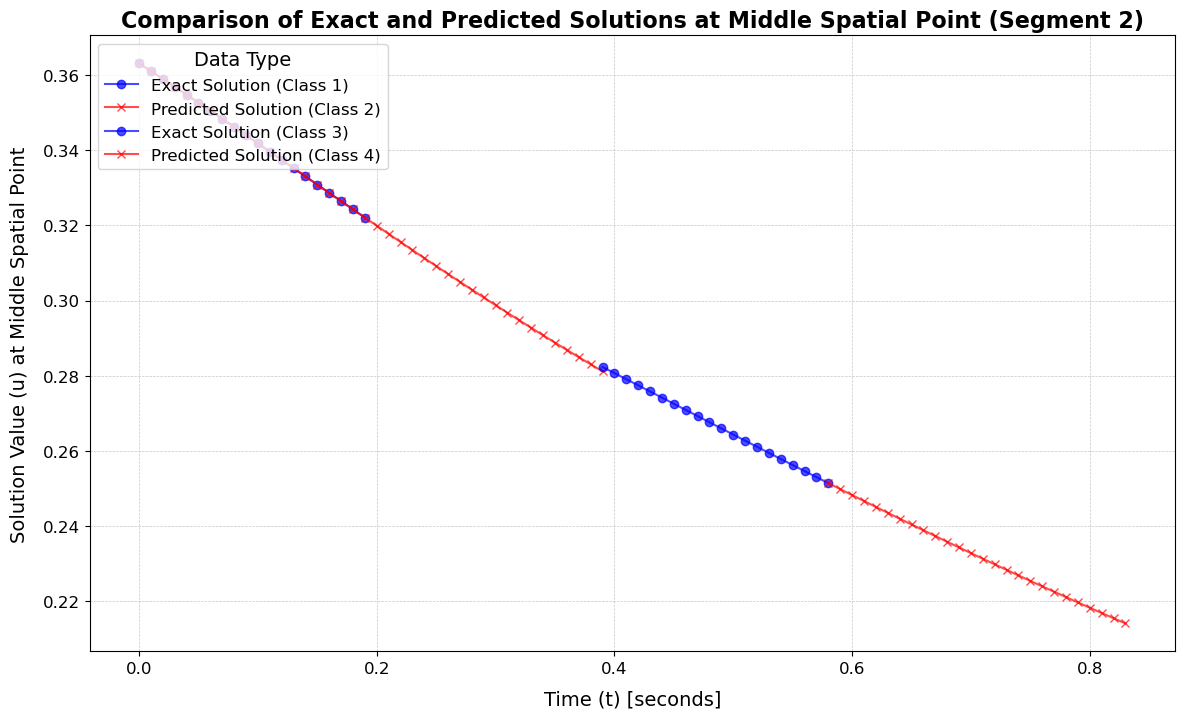

In [43]:
# Define the range of time values for the first segment
t_values_1 = np.arange(0.39, 0.39 + m * dt, dt)[:m]  # m time steps

# Generate the data for u(ti, xj) using the exact solution
u_values = []
for t in t_values_1:
    u_t = exact_solution(x_values, t)  # Compute the exact solution at time t
    u_values.append(u_t)

# Create a pandas DataFrame from the calculated values
u_df_1 = pd.DataFrame(u_values)

# Convert the DataFrame to a NumPy array
u_matrix = u_df_1.values

# Perform Singular Value Decomposition (SVD)
U, S, V = svd(u_matrix, full_matrices=False)

# Convert the singular values into a diagonal matrix
S_matrix = np.diag(S)

# Convert SVD components into DataFrames for clarity
U_df = pd.DataFrame(U, index=u_df.index, columns=[f"U{i+1}" for i in range(U.shape[1])])
S_df = pd.DataFrame(S_matrix, index=[f"S{i+1}" for i in range(S_matrix.shape[0])],
                    columns=[f"S{i+1}" for i in range(S_matrix.shape[1])])
V_df = pd.DataFrame(V, columns=u_df.columns, index=[f"V{i+1}" for i in range(V.shape[0])])

# Convert the DataFrames back to NumPy arrays for further calculations
U = U_df.values
S = np.diag(S_df.values.diagonal())  # Ensure S is a diagonal matrix
V = V_df.values

# Initialize the rank-k approximation matrix
A_k = np.zeros((len(t_values), len(x_values)))

# Truncate the SVD components to rank-k approximation (k = 2)
k = 2
U_k = U[:, :k]  # Truncated left singular vectors
S_k = S[:k, :k]  # Truncated diagonal matrix of singular values
V_k = V[:k, :]  # Truncated right singular vectors

# Compute the rank-k approximation matrix
for g in range(k):
    U_g = U_k[:, g]  # g-th left singular vector
    S_g = S_k[g, g]  # g-th singular value
    V_g = V_k[g, :]  # g-th right singular vector

    # Compute the contribution of the g-th mode and add to A_k
    A_k += S_g * (U_g.reshape(-1, 1) @ V_g.reshape(1, -1))

# Convert the rank-k approximation matrix into a DataFrame for better interpretation
A_k_df_1 = pd.DataFrame(A_k)

# Initialize Gaussian Process Regressors (GPR) for each left singular vector
gpr_models = []
kernel = C(100.0, (1e-3, 1e3)) * RBF(0.1, (1e-3, 1e3))  # Define kernel

for i in range(U_k.shape[1]):
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, random_state=0)
    gpr.fit(t_values_1.reshape(-1, 1), U_k[:, i])  # Fit the GPR model
    gpr_models.append(gpr)

# Generate predictions for new time points
t_new_1 = np.arange(0.39, 0.39 + 5 * m * dt, dt)  # Define new time points
t_new_1 = t_new_1.reshape(-1, 1)

predictions = []
std_devs = []
for model in gpr_models:
    pred, std = model.predict(t_new_1, return_std=True)  # Predict and get uncertainties
    predictions.append(pred)
    std_devs.append(std)

# Stop predictions if uncertainty exceeds a threshold
error_threshold = 0.001
for t_idx, t in enumerate(t_new_1.flatten()):
    if any(std[t_idx] > error_threshold for std in std_devs):
        print(f"Stopping prediction at t = {t:.2f} due to high uncertainty.")
        break

# Combine predicted SVD components to reconstruct the matrix
U_k_pred = np.array(predictions)
A_pred = np.zeros((len(t_new_1), len(x_values)))
for g in range(k):
    U_g_pred = np.array([predictions[g]]).T  # Predicted g-th singular vector
    S_g = S_k[g, g]  # Singular value for the g-th mode
    V_g = V_k[g, :]  # g-th right singular vector

    # Compute the contribution of the g-th mode
    A_pred += S_g * (U_g_pred @ V_g.reshape(1, -1))

# Convert the predicted matrix into a DataFrame
A_pred_df_1 = pd.DataFrame(A_pred)

# Add exact solution data to the final DataFrame
t_new_values = t_values_1.flatten()
A_exact_middle = A_k_df_1.iloc[:, middle_point_idx]  # Middle column of exact data

new_rows = pd.DataFrame({
    "t": t_values_1,
    "u": A_exact_middle,
    "class": [3] * len(t_new_values)
})

final = pd.concat([final, new_rows], ignore_index=True)

# Add predicted data to the final DataFrame
t_new_values = t_new_1[m-1:84-39].flatten()
A_pred_middle = A_pred_df_1.iloc[m-1:84-39, middle_point_idx]

new_rows = pd.DataFrame({
    "t": t_new_values,
    "u": A_pred_middle,
    "class": [4] * len(t_new_values)
})

final = pd.concat([final, new_rows], ignore_index=True)

# Plot the data in `final` with both points and lines
plt.figure(figsize=(14, 8))  # Adjusted figure size for better visibility

# Plot exact solutions (Class 1)
class_1 = final[final["class"] == 1]
plt.plot(class_1["t"], class_1["u"], 'o-', color='blue', label="Exact Solution (Class 1)", alpha=0.7, markersize=6)

# Plot predicted solutions (Class 2)
class_2 = final[final["class"] == 2]
plt.plot(class_2["t"], class_2["u"], 'x-', color='red', label="Predicted Solution (Class 2)", alpha=0.7, markersize=6)

# Plot exact solutions (Class 3)
class_3 = final[final["class"] == 3]
plt.plot(class_3["t"], class_3["u"], 'o-', color='blue', label="Exact Solution (Class 3)", alpha=0.7, markersize=6)

# Plot predicted solutions (Class 4)
class_4 = final[final["class"] == 4]
plt.plot(class_4["t"], class_4["u"], 'x-', color='red', label="Predicted Solution (Class 4)", alpha=0.7, markersize=6)

# Add detailed labels and title
plt.title("Comparison of Exact and Predicted Solutions at Middle Spatial Point (Segment 2)", fontsize=16, fontweight='bold')
plt.xlabel("Time (t) [seconds]", fontsize=14, labelpad=10)
plt.ylabel("Solution Value (u) at Middle Spatial Point", fontsize=14, labelpad=10)

# Add a legend with a title for better clarity
plt.legend(title="Data Type", fontsize=12, title_fontsize=14, loc="upper left", frameon=True)

# Add grid for better readability with specific styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Stopping prediction at t = 1.19 due to high uncertainty.


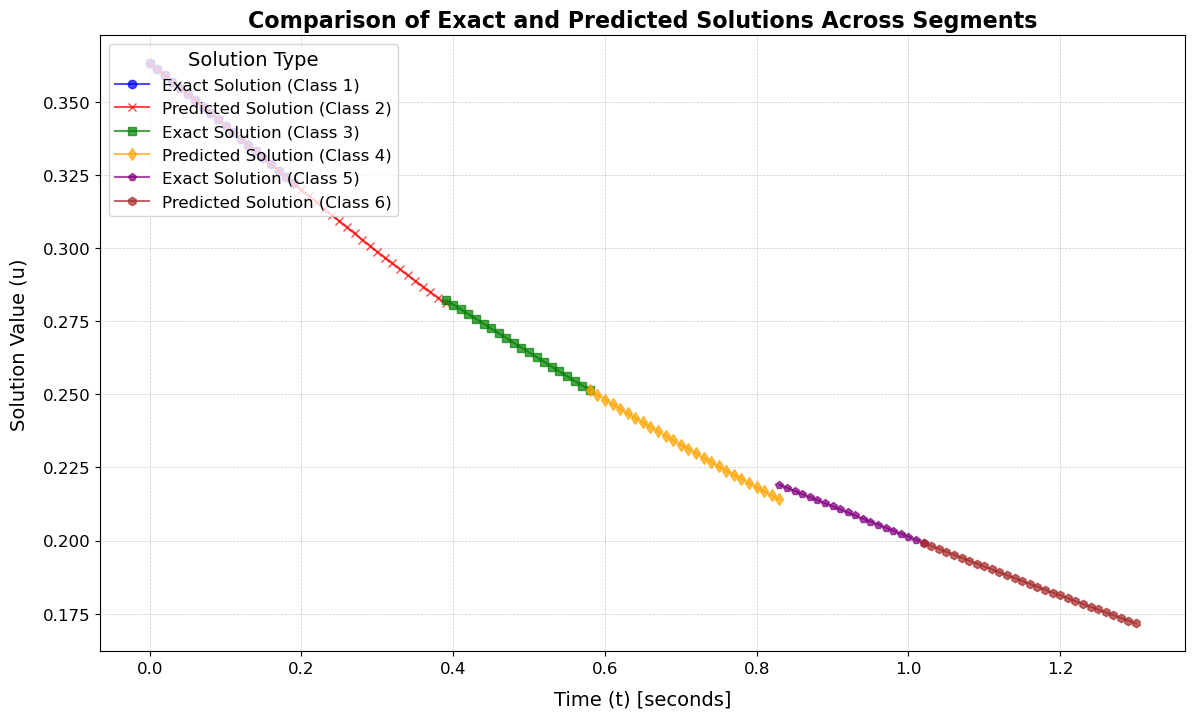

In [44]:
# Define the range of time values for the second segment
t_values_2 = np.arange(0.83, 0.83 + m * dt, dt)[:m]  # Generate m time steps starting from 0.83

# Generate the data for u(ti, xj) using the exact solution
u_values = []
for t in t_values_2:
    u_t = exact_solution(x_values, t)  # Compute the exact solution at time t
    u_values.append(u_t)

# Create a pandas DataFrame from the calculated values
u_df_2 = pd.DataFrame(u_values)

# Convert the DataFrame to a NumPy array for Singular Value Decomposition (SVD)
u_matrix = u_df_2.values

# Perform SVD
U, S, V = svd(u_matrix, full_matrices=False)

# Convert the singular values into a diagonal matrix
S_matrix = np.diag(S)

# Convert SVD components into DataFrames for better understanding
U_df = pd.DataFrame(U, index=u_df.index, columns=[f"U{i+1}" for i in range(U.shape[1])])
S_df = pd.DataFrame(S_matrix, index=[f"S{i+1}" for i in range(S_matrix.shape[0])],
                    columns=[f"S{i+1}" for i in range(S_matrix.shape[1])])
V_df = pd.DataFrame(V, columns=u_df.columns, index=[f"V{i+1}" for i in range(V.shape[0])])

# Convert the DataFrames back to NumPy arrays for further calculations
U = U_df.values
S = np.diag(S_df.values.diagonal())  # Ensure S is a diagonal matrix
V = V_df.values

# Initialize the rank-k approximation matrix
A_k = np.zeros((len(t_values), len(x_values)))

# Truncate the SVD components to rank-k approximation (k = 2)
k = 2
U_k = U[:, :k]  # Truncated left singular vectors
S_k = S[:k, :k]  # Truncated diagonal matrix of singular values
V_k = V[:k, :]  # Truncated right singular vectors

# Compute the rank-k approximation matrix
for g in range(k):
    U_g = U_k[:, g]  # g-th left singular vector
    S_g = S_k[g, g]  # g-th singular value
    V_g = V_k[g, :]  # g-th right singular vector

    # Compute the contribution of the g-th mode and add to A_k
    A_k += S_g * (U_g.reshape(-1, 1) @ V_g.reshape(1, -1))

# Convert the rank-k approximation matrix into a DataFrame
A_k_df_2 = pd.DataFrame(A_k)

# Initialize Gaussian Process Regressors (GPR) for each left singular vector
gpr_models = []
kernel = C(100.0, (1e-3, 1e3)) * RBF(0.1, (1e-3, 1e3))  # Define the kernel for GPR

for i in range(U_k.shape[1]):
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, random_state=0)
    gpr.fit(t_values_2.reshape(-1, 1), U_k[:, i])  # Fit the GPR model to the singular vector
    gpr_models.append(gpr)

# Output trained models for inspection
gpr_models

# Predict values for new time points
t_new_2 = np.arange(0.83, 0.83 + 5 * m * dt, dt)  # Define new time points
t_new_2 = t_new_2.reshape(-1, 1)

# Initialize lists to store predictions and standard deviations
predictions = []
std_devs = []
for model in gpr_models:
    pred, std = model.predict(t_new_2, return_std=True)  # Predict values and uncertainties
    predictions.append(pred)
    std_devs.append(std)

# Stop predictions if uncertainty exceeds a threshold
error_threshold = 0.001  # Threshold for stopping predictions
for t_idx, t in enumerate(t_new_2.flatten()):
    if any(std[t_idx] > error_threshold for std in std_devs):
        print(f"Stopping prediction at t = {t:.2f} due to high uncertainty.")
        break

# Combine predicted SVD components to reconstruct the matrix
U_k_pred = np.array(predictions)
A_pred = np.zeros((len(t_new_2), len(x_values)))
for g in range(k):
    U_g_pred = np.array([predictions[g]]).T  # Predicted g-th singular vector
    S_g = S_k[g, g]  # Singular value for the g-th mode
    V_g = V_k[g, :]  # g-th right singular vector

    # Compute the contribution of the g-th mode
    A_pred += S_g * (U_g_pred @ V_g.reshape(1, -1))

# Convert the predicted matrix into a DataFrame
A_pred_df_2 = pd.DataFrame(A_pred)

# Add exact solution data to the final DataFrame
t_new_values = t_values_2.flatten()
A_exact_middle = A_k_df_2.iloc[:, middle_point_idx]  # Extract middle column of exact data

new_rows = pd.DataFrame({
    "t": t_values_2,
    "u": A_exact_middle,
    "class": [5] * len(t_new_values)  # Assign class 5
})

final = pd.concat([final, new_rows], ignore_index=True)

# Add predicted data to the final DataFrame
t_new_values = t_new_2[m-1:130-82].flatten()  # Extract the desired range
A_pred_middle = A_pred_df_2.iloc[m-1:130-82, middle_point_idx]

new_rows = pd.DataFrame({
    "t": t_new_values,
    "u": A_pred_middle,
    "class": [6] * len(t_new_values)  # Assign class 6
})

final = pd.concat([final, new_rows], ignore_index=True)

# Plot the data in `final` with both points and lines, focusing on Class 1 to Class 6
plt.figure(figsize=(14, 8))  # Adjusted figure size for better visibility

# Class 1 to Class 6 plotting
class_labels = {
    1: "Exact Solution (Class 1)",
    2: "Predicted Solution (Class 2)",
    3: "Exact Solution (Class 3)",
    4: "Predicted Solution (Class 4)",
    5: "Exact Solution (Class 5)",
    6: "Predicted Solution (Class 6)"
}
colors = ["blue", "red", "green", "orange", "purple", "brown"]
markers = ["o", "x", "s", "d", "p", "h"]

for cls, label in class_labels.items():
    data = final[final["class"] == cls]
    plt.plot(data["t"], data["u"], markers[cls-1] + "-", color=colors[cls-1], label=label, alpha=0.7, markersize=6)

# Add detailed labels and title
plt.title("Comparison of Exact and Predicted Solutions Across Segments", fontsize=16, fontweight='bold')
plt.xlabel("Time (t) [seconds]", fontsize=14, labelpad=10)
plt.ylabel("Solution Value (u)", fontsize=14, labelpad=10)

# Add a legend with improved styling
plt.legend(title="Solution Type", fontsize=12, title_fontsize=14, loc="upper left", frameon=True)

# Add grid for better readability with specific styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Stopping prediction at t = 1.57 due to high uncertainty.


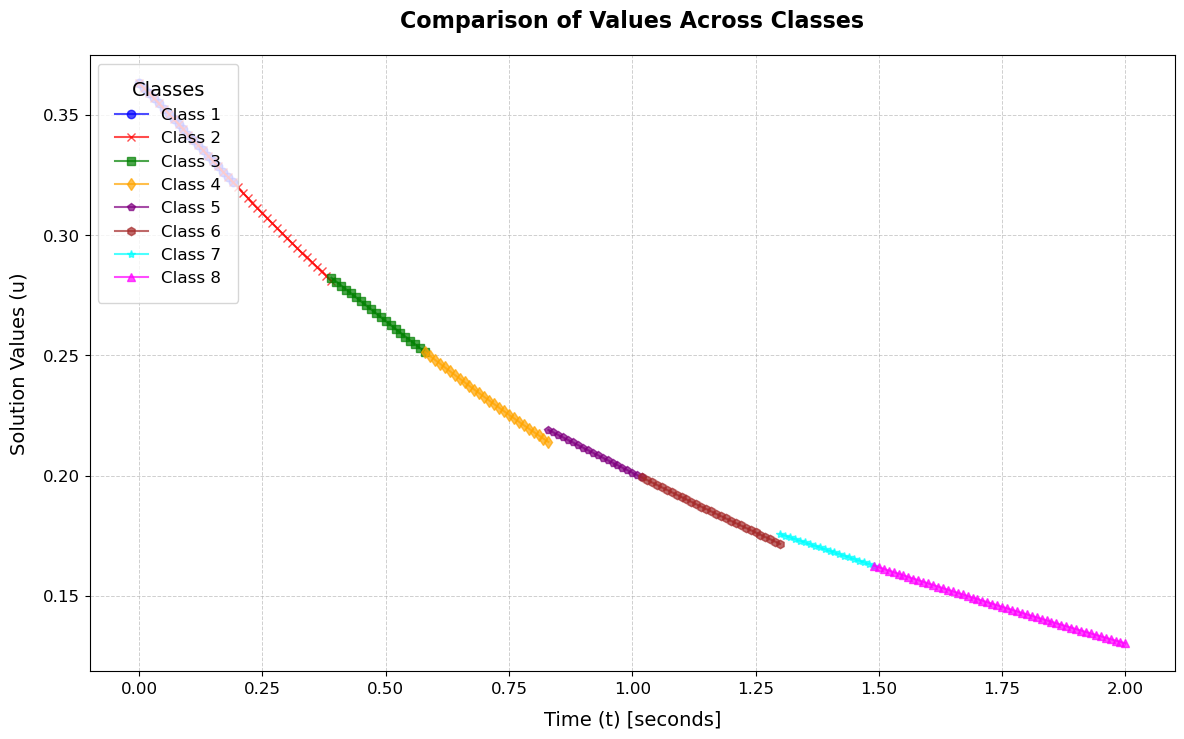

In [45]:
# Define the range of time values for the third segment
t_values_3 = np.arange(1.3, 1.3 + m * dt, dt)[:m]  # Generate m time steps starting at 1.3

# Generate the data for u(ti, xj) using the exact solution
u_values = []
for t in t_values_3:
    u_t = exact_solution(x_values, t)  # Compute the exact solution at time t
    u_values.append(u_t)

# Create a pandas DataFrame from the calculated values
u_df_3 = pd.DataFrame(u_values)

# Convert the DataFrame to a NumPy array for SVD
u_matrix = u_df_3.values

# Perform Singular Value Decomposition (SVD)
U, S, V = svd(u_matrix, full_matrices=False)

# Convert the singular values into a diagonal matrix
S_matrix = np.diag(S)

# Convert SVD components into DataFrames for clarity and naming
U_df = pd.DataFrame(U, index=u_df.index, columns=[f"U{i+1}" for i in range(U.shape[1])])
S_df = pd.DataFrame(S_matrix, index=[f"S{i+1}" for i in range(S_matrix.shape[0])],
                    columns=[f"S{i+1}" for i in range(S_matrix.shape[1])])
V_df = pd.DataFrame(V, columns=u_df.columns, index=[f"V{i+1}" for i in range(V.shape[0])])

# Convert the DataFrames back to NumPy arrays for further calculations
U = U_df.values
S = np.diag(S_df.values.diagonal())  # Ensure S is a diagonal matrix
V = V_df.values

# Initialize the rank-k approximation matrix
A_k = np.zeros((len(t_values), len(x_values)))

# Truncate the SVD components to rank-k approximation (k = 2)
k = 2
U_k = U[:, :k]  # Truncated left singular vectors
S_k = S[:k, :k]  # Truncated diagonal matrix of singular values
V_k = V[:k, :]  # Truncated right singular vectors

# Compute the rank-k approximation matrix
for g in range(k):
    U_g = U_k[:, g]  # g-th left singular vector
    S_g = S_k[g, g]  # g-th singular value
    V_g = V_k[g, :]  # g-th right singular vector

    # Compute the contribution of the g-th mode and add to A_k
    A_k += S_g * (U_g.reshape(-1, 1) @ V_g.reshape(1, -1))

# Convert the rank-k approximation matrix into a DataFrame
A_k_df_3 = pd.DataFrame(A_k)

# Initialize Gaussian Process Regressors (GPR) for each left singular vector
gpr_models = []
kernel = C(100.0, (1e-3, 1e3)) * RBF(0.1, (1e-3, 1e3))  # Define the kernel for GPR

for i in range(U_k.shape[1]):
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, random_state=0)
    gpr.fit(t_values_3.reshape(-1, 1), U_k[:, i])  # Fit the GPR model to the singular vector
    gpr_models.append(gpr)

# Predict values for new time points
t_new_3 = np.arange(1.3, 1.3 + 5 * m * dt, dt)  # Define new time points
t_new_3 = t_new_3.reshape(-1, 1)

predictions = []
std_devs = []
for model in gpr_models:
    pred, std = model.predict(t_new_3, return_std=True)  # Predict values and uncertainties
    predictions.append(pred)
    std_devs.append(std)

# Stop predictions if uncertainty exceeds a threshold
error_threshold = 0.0001  # Threshold for stopping predictions
for t_idx, t in enumerate(t_new_3.flatten()):
    if any(std[t_idx] > error_threshold for std in std_devs):
        print(f"Stopping prediction at t = {t:.2f} due to high uncertainty.")
        break

# Combine predicted SVD components to reconstruct the matrix
U_k_pred = np.array(predictions)
A_pred = np.zeros((len(t_new_3), len(x_values)))
for g in range(k):
    U_g_pred = np.array([predictions[g]]).T  # Predicted g-th singular vector
    S_g = S_k[g, g]  # Singular value for the g-th mode
    V_g = V_k[g, :]  # g-th right singular vector

    # Compute the contribution of the g-th mode
    A_pred += S_g * (U_g_pred @ V_g.reshape(1, -1))

# Convert the predicted matrix into a DataFrame
A_pred_df_3 = pd.DataFrame(A_pred)

# Add exact solution data to the final DataFrame
t_new_values = t_values_3.flatten()
A_exact_middle = A_k_df_3.iloc[:, middle_point_idx]  # Extract middle column of exact data

new_rows = pd.DataFrame({
    "t": t_values_3,
    "u": A_exact_middle,
    "class": [7] * len(t_new_values)  # Assign class 7
})

final = pd.concat([final, new_rows], ignore_index=True)

# Add predicted data to the final DataFrame
t_new_values = t_new_3[m-1:200-129].flatten()  # Extract the desired range
A_pred_middle = A_pred_df_3.iloc[m-1:200-129, middle_point_idx]

new_rows = pd.DataFrame({
    "t": t_new_values,
    "u": A_pred_middle,
    "class": [8] * len(t_new_values)  # Assign class 8
})

final = pd.concat([final, new_rows], ignore_index=True)

# Plot the data with points and lines for different classes
plt.figure(figsize=(14, 8))  # Increased figure size for better visibility

# Plot each class with distinct styles and colors
class_labels = {
    1: "Class 1",
    2: "Class 2",
    3: "Class 3",
    4: "Class 4",
    5: "Class 5",
    6: "Class 6",
    7: "Class 7",
    8: "Class 8"
}
colors = ["blue", "red", "green", "orange", "purple", "brown", "cyan", "magenta"]
markers = ["o", "x", "s", "d", "p", "h", "*", "^"]

# Iterate through each class and plot
for cls, label in class_labels.items():
    data = final[final["class"] == cls]  # Filter data by class
    plt.plot(
        data["t"],
        data["u"],
        markers[cls - 1] + "-",
        color=colors[cls - 1],
        label=label,
        alpha=0.7,
        markersize=6
    )

# Add detailed labels and title
plt.title("Comparison of Values Across Classes", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Time (t) [seconds]", fontsize=14, labelpad=10)
plt.ylabel("Solution Values (u)", fontsize=14, labelpad=10)

# Add a legend with improved styling
plt.legend(
    title="Classes",
    fontsize=12,
    title_fontsize=14,
    loc="upper left",
    frameon=True,
    borderpad=1
)

# Add a grid with enhanced styling
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()
